# 1. Import libraries and modules.

Let's start by importing numpy and setting a seed for the computer's pseudorandom number generator. This allows us to reproduce the results from our script:

In [788]:
import numpy as np
np.random.seed(123)

Next, we'll import the Sequential model type from Keras. This is simply a linear stack of neural network layers, and it's perfect for the type of feed-forward CNN we're building in this tutorial.

In [789]:
# set image dimension ordering (differs between Theano and Tensorflow)
from keras import backend as K
K.set_image_dim_ordering('th')
# import sequential model
from keras.models import Sequential

Next, let's import the "core" layers from Keras. These are the layers that are used in almost any neural network:

In [790]:
from keras.layers import Dense, Dropout, Activation, Flatten

Then, we'll import the CNN layers from Keras. These are the convolutional layers that will help us efficiently train on image data:

In [791]:
from keras.layers import Convolution2D, MaxPooling2D

Finally, we'll import some utilities. This will help us transform our data later:

In [792]:
from keras.utils import np_utils

Now we have everything we need to build our neural network architecture.

# 2. Load image data from MNIST.

MNIST is a great dataset for getting started with deep learning and computer vision. It's a big enough challenge to warrant neural networks, but it's manageable on a single computer. We discuss it more in our post: [6 Fun Machine Learning Projects for Beginners.](https://elitedatascience.com/machine-learning-projects-for-beginners)

The Keras library conveniently includes it already. We can load it like so:

In [793]:
from keras.datasets import mnist
 
# Load pre-shuffled MNIST data into train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()

We can look at the shape of the dataset:

In [794]:
print (X_train.shape)
# (60000, 28, 28)

(60000, 28, 28)


Great, so it appears that we have 60,000 samples in our training set, and the images are 28 pixels x 28 pixels each. We can confirm this by plotting the first sample in matplotlib:

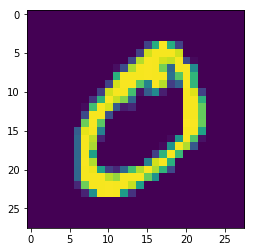

In [795]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.imshow(X_train[1])

In general, when working with computer vision, it's helpful to visually plot the data before doing any algorithm work. It's a quick sanity check that can prevent easily avoidable mistakes (such as misinterpreting the data dimensions).

# 3. Preprocess input data for Keras.

When using the Theano backend, you must explicitly declare a dimension for the depth of the input image. For example, a full-color image with all 3 RGB channels will have a depth of 3.

Our MNIST images only have a depth of 1, but we must explicitly declare that.

In other words, we want to transform our dataset from having shape (n, width, height) to (n, depth, width, height).

Here's how we can do that easily:

In [796]:
X_train = X_train.reshape(X_train.shape[0], 1, 28, 28)
X_test = X_test.reshape(X_test.shape[0], 1, 28, 28)

To confirm, we can print X_train's dimensions again:

In [797]:
print (X_train.shape)
# (60000, 1, 28, 28)

(60000, 1, 28, 28)


The final preprocessing step for the input data is to convert our data type to float32 and normalize our data values to the range [0, 1].

In [798]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

Now, our input data are ready for model training.

# 4. Preprocess class labels for Keras.

Next, let's take a look at the shape of our class label data:

In [799]:
print (y_train.shape)
# (60000,)

(60000,)


Hmm... that may be problematic. We should have 10 different classes, one for each digit, but it looks like we only have a 1-dimensional array. Let's take a look at the labels for the first 10 training samples:

In [800]:
print (y_train[:10])
# [5 0 4 1 9 2 1 3 1 4]

[5 0 4 1 9 2 1 3 1 4]


And there's the problem. The y_train and y_test data are not split into 10 distinct class labels, but rather are represented as a single array with the class values.

We can fix this easily:

In [801]:
# Convert 1-dimensional class arrays to 10-dimensional class matrices
Y_train = np_utils.to_categorical(y_train, 10)
Y_test = np_utils.to_categorical(y_test, 10)

Now we can take another look:

In [802]:
print (Y_train.shape)
# (60000, 10)

(60000, 10)


There we go... much better!

# 5.  Define model architecture.

Now we're ready to define our model architecture. In actual R&D work, researchers will spend a considerable amount of time studying model architectures.

To keep this tutorial moving along, we're not going to discuss the theory or math here. This alone is a rich and meaty field, and we recommend the CS231n class mentioned earlier for those who want to learn more.

Plus, when you're just starting out, you can just replicate proven architectures from academic papers or use existing examples. Here's a list of [example implementations in Keras.](https://github.com/fchollet/keras/tree/master/examples)

Let's start by declaring a sequential model format:

In [803]:
model = Sequential()

Next, we declare the input layer:

In [804]:
from keras.layers.convolutional import Conv2D
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(1,28,28)))

The input shape parameter should be the shape of 1 sample. In this case, it's the same (1, 28, 28) that corresponds to  the (depth, width, height) of each digit image.

But what do the first 3 parameters represent? They correspond to the number of convolution filters to use, the number of rows in each convolution kernel, and the number of columns in each convolution kernel, respectively.

*Note: The step size is (1,1) by default, and it can be tuned using the 'subsample' parameter.

We can confirm this by printing the shape of the current model output:

In [805]:
print (model.output_shape)
# (None, 32, 26, 26)

(None, 32, 26, 26)


Next, we can simply add more layers to our model like we're building legos:

In [806]:
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

Again, we won't go into the theory too much, but it's important to highlight the Dropout layer we just added. This is a method for regularizing our model in order to prevent overfitting. You can read more about it [here](https://www.quora.com/How-does-the-dropout-method-work-in-deep-learning).

MaxPooling2D is a way to reduce the number of parameters in our model by sliding a 2x2 pooling filter across the previous layer and taking the max of the 4 values in the 2x2 filter.

So far, for model parameters, we've added two Convolution layers. To complete our model architecture, let's add a fully connected layer and then the output layer:

In [807]:
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

For Dense layers, the first parameter is the output size of the layer. Keras automatically handles the connections between layers.

Note that the final layer has an output size of 10, corresponding to the 10 classes of digits.

Also note that the weights from the Convolution layers must be flattened (made 1-dimensional) before passing them to the fully connected Dense layer.

Here's how the entire model architecture looks together:

In [808]:
model = Sequential()
 
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(1,28,28)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
 
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

Now all we need to do is define the loss function and the optimizer, and then we'll be ready to train it.

# 6. Compile model.

Now we're in the home stretch! The hard part is already over.

We just need to compile the model and we'll be ready to train it. When we compile the model, we declare the loss function and the optimizer (SGD, Adam, etc.).

In [809]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Keras has a variety of [loss functions](https://keras.io/objectives/) and out-of-the-box [optimizers](https://keras.io/optimizers/) to choose from.

# 7. Fit model on training data.

To fit the model, all we have to do is declare the batch size and number of epochs to train for, then pass in our training data.

In [810]:
history = model.fit(X_train, Y_train, 
          batch_size=32, epochs=1, verbose=1)

print(history.history.keys())

# Epoch 1/10
# 7744/60000 [==>...........................] - ETA: 96s - loss: 0.5806 - acc: 0.

Epoch 1/1
60000/60000 [==============================] - 336s - loss: 0.2077 - acc: 0.9367   
dict_keys(['loss', 'acc'])


Easy, huh?

You can also use a variety of [callbacks](https://keras.io/callbacks/) to set early-stopping rules, save model weights along the way, or log the history of each training epoch.

# 8. Evaluate model on test data.

Finally, we can evaluate our model on the test data:

In [811]:
score = model.evaluate(X_test, Y_test, verbose=0)

print (score)

[0.047247367119963746, 0.98499999999999999]


Congratulations... you've made it to the end of this Keras tutorial!

We've just completed a whirlwind tour of Keras's core functionality, but we've only really scratched the surface. Hopefully you've gained the foundation to further explore all that Keras has to offer.

For continued learning, we recommend studying other [example models in Keras](https://github.com/fchollet/keras/tree/master/examples) and Stanford's [computer vision class](http://cs231n.stanford.edu/).